In [1]:
import numpy as np

In [2]:
np.__version__

'1.13.3'

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import skimage

In [5]:
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

In [6]:
import skimage.io as io

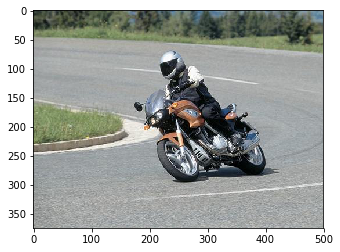

In [7]:
img = io.imread("moto.jpg")
img = img_as_float(img)
plt.imshow(img)

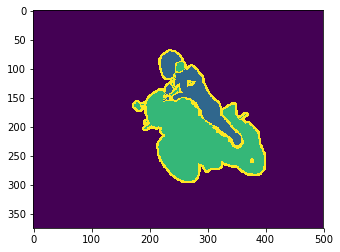

In [8]:
seg_orig = io.imread("moto_seg.png")
_, true_seg = np.unique(seg_orig.reshape(-1, 3), axis=0, return_inverse=True)
true_seg = true_seg.reshape(seg_orig.shape[:2])
plt.imshow(true_seg)

# Felzenszwalb's Method

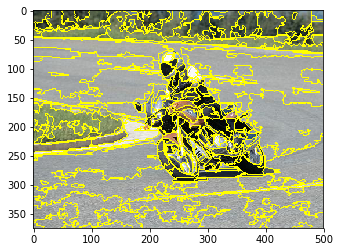

In [9]:
segments_fz = felzenszwalb(img, 
                           scale=100,   # Higher means larger clusters.
                           sigma=0.5,   # Width of Gaussian kernel
                           min_size=50) # Minimum component size
plt.imshow(mark_boundaries(img, segments_fz))

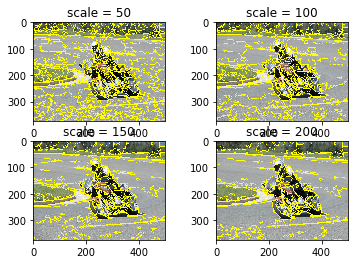

In [10]:
_, axs = plt.subplots(2, 2)
scales = [50, 100, 150, 200]

for ax, scale in zip(axs.flat, scales):
    segments_fz = felzenszwalb(img, scale=scale, sigma=0.5, min_size=50)
    ax.imshow(mark_boundaries(img, segments_fz))
    ax.set_title("scale = {}".format(scale))

# SLIC Method

(Basically k-Means clustering with size constraints)

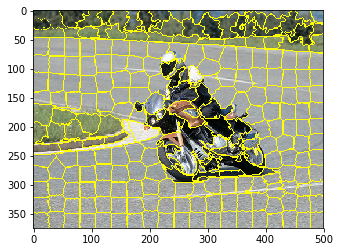

In [11]:
segments_slic = slic(img, 
                     n_segments=250, # The (approximate) number of labels in the segmented output
                     compactness=10, # Balances color proximity and space proximity.
                     sigma=1) # Width of Gaussian smoothing kernel
plt.imshow(mark_boundaries(img, segments_slic))

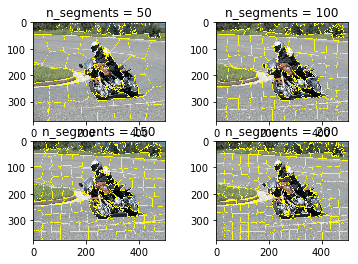

In [12]:
_, axs = plt.subplots(2, 2)
num_segs = [50, 100, 150, 200]

for ax, segs in zip(axs.flat, num_segs):
    segments_slic = slic(img, n_segments=segs, compactness=10, sigma=1)
    ax.imshow(mark_boundaries(img, segments_slic))
    ax.set_title("n_segments = {}".format(segs))

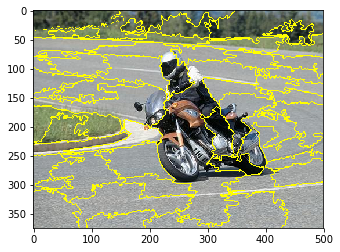

In [13]:
segments_slic = slic(img, 
                     n_segments=100, # The (approximate) number of labels in the segmented output
                     compactness=1, # Balances color proximity and space proximity.
                     sigma=1) # Width of Gaussian smoothing kernel
plt.imshow(mark_boundaries(img, segments_slic))

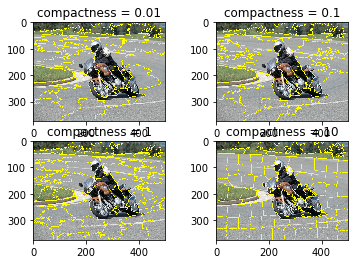

In [14]:
_, axs = plt.subplots(2, 2)
compactness = [0.01, 0.1, 1, 10]

for ax, comp in zip(axs.flat, compactness):
    segments_slic = slic(img, n_segments=100, compactness=comp, sigma=1)
    ax.imshow(mark_boundaries(img, segments_slic))
    ax.set_title("compactness = {}".format(comp))

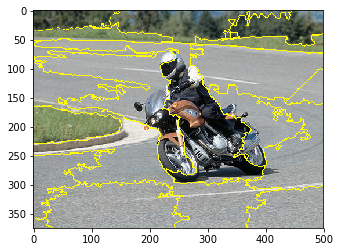

In [15]:
segments_slic = slic(img, 
                     n_segments=50, # The (approximate) number of labels in the segmented output
                     compactness=0.5, # Balances color proximity and space proximity.
                     sigma=1) # Width of Gaussian smoothing kernel
plt.imshow(mark_boundaries(img, segments_slic))

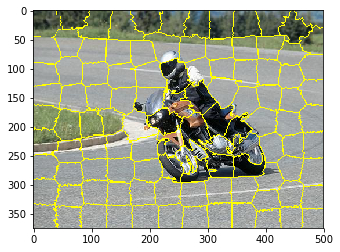

In [16]:
segments_slic = slic(img, slic_zero=True) # Run SLIC-zero, the zero-parameter mode of SLIC.
plt.imshow(mark_boundaries(img, segments_slic))

# Naive Superpixel clustering

In [17]:
segments_slic.shape, np.unique(segments_slic).size

((375, 500), 108)

In [18]:
img[segments_slic == 0].mean(axis=0)

array([ 0.31905015,  0.35740642,  0.27581388])

In [19]:
M = np.stack([
    img[segments_slic == i].mean(axis=0)
    for i in np.unique(segments_slic)
])
M.shape

(108, 3)

In [20]:
from sklearn.cluster import KMeans

In [21]:
clusts = KMeans(4).fit_predict(M)

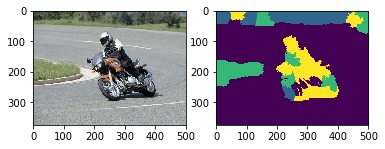

In [22]:
segments_clust = clusts[segments_slic]

_, (left, right) = plt.subplots(1,2)

left.imshow(img)
right.imshow(segments_clust)

# Evaluation

Following metric from Martial Hebert: https://www.cs.cmu.edu/~hebert/segs.htm

In [23]:
from sklearn.metrics import adjusted_rand_score

In [24]:
adjusted_rand_score(true_seg.flat, segments_clust.flat)

0.3148126695573055

Is this metric sensitive to label order?

In [27]:
segments_clust_ = segments_clust.copy()
idx = np.unique(segments_clust_)
np.random.shuffle(idx)
segments_clust_ = idx[segments_clust_]
adjusted_rand_score(true_seg.flat, segments_clust_.flat)

0.3148126695573055